In [8]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumBarunGothic')

In [3]:
#1. 교육 프로그램의 학습 효과 분석 보고서

np.random.seed(321)
n_students = 150
control_scores = np.random.normal(65, 10, n_students)
smartlearn_scores = np.random.normal(70, 12, n_students)
education_data = pd.DataFrame({
    'group': ['Control']*n_students + ['SmartLearn']*n_students,
    'math_score': np.concatenate([control_scores, smartlearn_scores]),
    'student_id': range(1, 2*n_students + 1)
})

print("📚 교육 프로그램 데이터 미리보기")
print(education_data.groupby('group')['math_score'].agg(['count', 'mean', 'std']).round(2))


📚 교육 프로그램 데이터 미리보기
            count   mean    std
group                          
Control       150  64.93   9.67
SmartLearn    150  70.47  11.29


In [4]:
#1.1. 기본 통계량 비교

control_mean = control_scores.mean()
smartlearn_mean = smartlearn_scores.mean()
control_se = control_scores.std() / np.sqrt(len(control_scores))
smartlearn_se = smartlearn_scores.std() / np.sqrt(len(smartlearn_scores))

print(f"대조군 수학 점수: {control_mean:.2f} ± {control_se:.2f}")
print(f"SmartLearn 수학 점수: {smartlearn_mean:.2f} ± {smartlearn_se:.2f}")

#SmartLearn을 사용한 학생들이 사용하지 않은 학생들보다 평균적으로 약 5.54점 높은 점수를 얻음

대조군 수학 점수: 64.93 ± 0.79
SmartLearn 수학 점수: 70.47 ± 0.92


In [5]:
#1.2. 통계적 유의성 검증

control_group = education_data[education_data['group'] == 'Control']['math_score']
smartlearn_group = education_data[education_data['group'] == 'SmartLearn']['math_score']
t_stat, p_value = stats.ttest_ind(smartlearn_group, control_group)

print(f"t-통계량: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")
alpha = 0.05
if p_value < alpha:
    print("✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!")
else:
    print("❌ SmartLearn 프로그램의 효과가 유의미하지 않습니다.")

#SmartLearn 프로그램의 성과가 우연히 나온 결과일 확률은 0.01%보다 작다
#일반적으로는 p-value가 0.05보다 작으면 통계적으로 유의미하다고 본다
#이 조건을 충족하기 때문에 대조군과의 성적 차이는 통계적으로 유의미하다

t-통계량: 4.565
p-value: 0.0000
✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!


In [6]:
#1.3. 효과 크기 평가

control_std = education_data[education_data['group'] == 'Control']['math_score'].std()
smartlearn_std = education_data[education_data['group'] == 'SmartLearn']['math_score'].std()
pooled_std = np.sqrt(((n_students-1)*control_std**2 + (n_students-1)*smartlearn_std**2)/(2*n_students-2))
cohens_d = (smartlearn_mean - control_mean) / pooled_std

print(f"Cohen's d: {cohens_d:.3f}")
if cohens_d > 0.8:
    print("→ 큰 효과크기 (학부모가 명확히 체감할 수 있는 수준)")
elif cohens_d > 0.5:
    print("→ 중간 효과크기 (교육적으로 의미있는 수준)")
else:
    print("→ 작은 효과크기 (미미한 개선 수준)")

#Cohen's d: 해당 차이가 얼마나 큰 의미를 갖는가
  #0.527: 중간 효과 크기로 크진 않지만 교육적으로 의미있는 수준으로 해석할 수 있다
  #학부모 입장에서는 어느정도는 능력 향상에 기여를 했다고 판단할 수 있을 것이다


Cohen's d: 0.527
→ 중간 효과크기 (교육적으로 의미있는 수준)


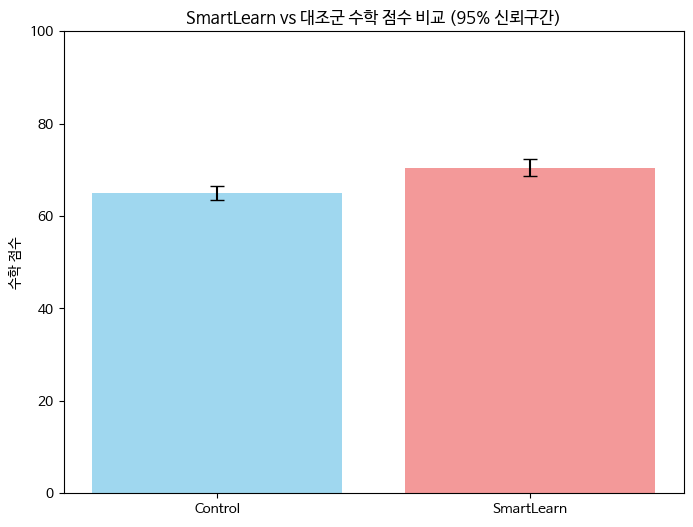

In [7]:
#1.4. 결과 시각화

plt.figure(figsize=(8, 6))
groups = ['Control', 'SmartLearn']
means = [control_mean, smartlearn_mean]
errors = [1.96 * control_se, 1.96 * smartlearn_se]
plt.bar(groups, means, yerr=errors, capsize=5, color=['skyblue', 'lightcoral'], alpha=0.8)
plt.ylabel('수학 점수')
plt.title('SmartLearn vs 대조군 수학 점수 비교 (95% 신뢰구간)')
plt.ylim(0, 100)
plt.show()

#SmartLearn 그룹의 막대가 대조군 보다 높다 > 평균의 차이가 있다 > 긍정적인 차이가 있다
#두 그릅 간의 오차 막대가 겹치기 않는다 > 두 그릅의 차이가 통계적으로 유의미하다

#SmartLearn 프로그램이 학생들의 수학 점수를 실질적으로 높게 향상 시키고 이는 통계적으로 유의미하다

In [9]:
#1.5. p-해킹 방지 방안

#p-해킹 방지 방안
  #1. 사전 등록: 연구 계획을 Open Science Framework(OSF)에 등록하여 분석 계획을 투명하게 공개.
  #2. 다중비교 보정: Bonferroni 또는 FDR 방법을 적용하여 다중 검정으로 인한 오류를 최소화.
  #3. 독립적 데이터셋을 이용한 결과 점증: 검증 데이터셋을 통해 해당 분석 결과다 동일하게 결과로 재현되는지 확인
    #결과 검증 측면에서, 우연이 아닌 다른 데이터에서도 일관되게 나타난다는 것을 보여주기 위해 필요하다
    #일반화 가능 결과이다


In [10]:
#1.6. 베이즈 인수 계산

#베이즈 인수: 두 가설의 상대적인 지지도

# 베이즈 인수 계산 (BIC 기반 근사)
# 대립가설(H1): SmartLearn 효과 있음 vs 귀무가설(H0): 효과 없음
n_total = 2 * n_students
bic_diff = t_stat**2 - np.log(n_total)
bf_10 = np.exp(bic_diff / 2)

print(f"베이즈 인수 (BF₁₀): {bf_10:.2f}")
if bf_10 > 10:
    print("→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)")
elif bf_10 > 3:
    print("→ 중간 증거 (H1 지지: SmartLearn 효과가 있을 가능성 높음)")
elif bf_10 > 1:
    print("→ 약한 증거 (H1 약간 지지)")
elif bf_10 > 0.33:
    print("→ 불분명한 증거 (결론 내리기 어려움)")
elif bf_10 > 0.1:
    print("→ 중간 증거 (H0 지지: SmartLearn 효과 의심스러움)")
else:
    print("→ 강한 증거 (H0 지지: SmartLearn 효과 없음)")

#대립 가설이 귀무가설보다 약 1935배 더 강력한 지지를 받는다
#SmartLearn 프로그램이 효과가 있다는 것이 매우 확실하다

베이즈 인수 (BF₁₀): 1934.97
→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)


#1.7. 경영진 보고서 작성

📋 경영진 보고서: SmartLearn 프로그램 효과 검증
==================================================
🎯 핵심 결과

• 대조군 수학 점수: 64.93 ± 0.79

• SmartLearn 수학 점수: 70.47 ± 0.92

• 점수 향상: SmartLearn 사용시 평균 5.54점 (약 8.5% 향상)

• 효과크기 (Cohen's d): 0.527 (교육학적으로 의미 있는 '중간 크기'의 효과)

• p-value: 0.0000 (통계적으로 매우 유의미, 우연일 확률 0.01% 미만)

• 베이즈 인수: 1934.97 (대립가설이 귀무가설보다 약 1935배 더 강력한 지지를 받는다)


💡 비즈니스 결론 및 권장사항:
- 상용화 결정: SmartLearn이 학생의 수학 점수를 높이는 것이 통계적으로 유의미하고, 실질적으로 의미 있는 수준으로 향상시키기 때문에 사용화 가능하다
- 마케팅 전략: 구체적인 수치 (약 8.5% 성적 상승)를 활용하여 학구열이 높은 지역을 타겟으로 마케팅을 먼저 시도한다. / 또래 학생이 밀집되어 있는 지역을 위주로 타겟팅을 한다.
- 투자 방향: 확보된 데이터를 기반으로 도출된 결과는, 실질적으로 의미가 있는 결과이다. 이 점을 어필해서 투자자에게 본 프로그램이 시장에서 성공 가능성이 있고 이는 믿을 만한 자료가 된다는 점을 주장한다.
- 교육부 대응 방안: 방과후 프로그램 및 학습 지원 프로그램 계획 시, 해당 보고서를 통해  이 프로그램이 의미가 있는 것이고, 이에 상응하는 유의미한 결과(성적 향상 등)가 나올 것이라는 것을 어필하여 지원이나 근거 자료로 사용할 수 있다.

⚠️ 리스크 및 제한사항:
- 장기적으로 보았을때 성적 유지 효과에도 유의미한지는 검증되어 있지 않다.
- 수학 과목 외적으로, 타 과목에 대한 학습 능력 전이 효과가 고려되고 있지 않다
- 성적 상위권/하위권, 학구열이 높은 지역/낮은 지역 등 잠재적 위험 요소를 고려하지 않고 분석을 진행하였다. 세부적으로 나눠, 사용자 맞춤형 분석이 필요할 것이다.
- 초기 데이터를 수집할 때, 전국 모든 학생들을 대변할 수 있는 데이터인지는 단정짓기 어렵다.


In [11]:
#2. 마케팅 캠페인 효과 분석 보고서

np.random.seed(456)
n_customers = 1000
ad_exposure = np.random.binomial(1, 0.6, n_customers)
ages = np.random.randint(20, 60, n_customers)
income = np.random.lognormal(np.log(50000), 0.4, n_customers)
purchase_amount = 100 + 50*ad_exposure + 0.5*ages + 0.0001*income + np.random.normal(0, 20, n_customers)
data_marketing = pd.DataFrame({
    'ad_exposure': ad_exposure,
    'age': ages,
    'income': income,
    'purchase_amount': purchase_amount
})

print("📢 마케팅 데이터 미리보기")
print(data_marketing.groupby('ad_exposure')['purchase_amount'].agg(['count', 'mean', 'std']).round(2))


📢 마케팅 데이터 미리보기
             count    mean    std
ad_exposure                      
0              386  124.60  22.35
1              614  175.32  21.69


📊 상관계수 매트릭스
                 ad_exposure    age  income  purchase_amount
ad_exposure            1.000  0.018  -0.050            0.748
age                    0.018  1.000  -0.034            0.203
income                -0.050 -0.034   1.000            0.046
purchase_amount        0.748  0.203   0.046            1.000


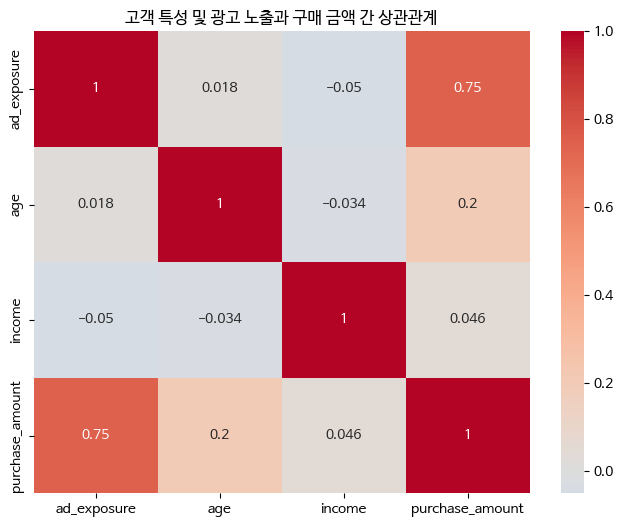

In [12]:
#2.1. 상관관계 탐색

correlation_matrix = data_marketing.corr()
print("📊 상관계수 매트릭스")
print(correlation_matrix.round(3))

# 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('고객 특성 및 광고 노출과 구매 금액 간 상관관계')
plt.show()


#ad_exposure - purchase_amount (0.748): 광고를 본 고객이 더 많이 구매를 한다. 마케팅 효과가 있다
#구매 금액을 높이는데 가장 영향을 많이 미치는 요소는 광고 노출이다

In [13]:
#2.2. 단순 비교와 한계

exposed_mean = data_marketing[data_marketing['ad_exposure'] == 1]['purchase_amount'].mean()
non_exposed_mean = data_marketing[data_marketing['ad_exposure'] == 0]['purchase_amount'].mean()
simple_difference = exposed_mean - non_exposed_mean

print(f"광고 노출 그룹 구매 금액: {exposed_mean:.2f}원")
print(f"광고 비노출 그룹 구매 금액: {non_exposed_mean:.2f}원")
print(f"단순 차이: {simple_difference:.2f}원")
print("⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움")
print("   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음")

#광고의 효과만으로 50.72원만큼의 차이가 나는 것은 아니다
  #고소득층 + 광고 효과 > 해당 그룹의 높은 구매력과 합려친 결과일 수도 있다
  #즉, 소득이라는 요인으로 과대평가 될수도 있다

#광고-구매액을 바로 인과관계로 증명하는 것은 옳지 않다


광고 노출 그룹 구매 금액: 175.32원
광고 비노출 그룹 구매 금액: 124.60원
단순 차이: 50.72원
⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움
   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음


In [14]:
#2.3. 다중회귀분석

X = data_marketing[['ad_exposure', 'age', 'income']]
y = data_marketing['purchase_amount']
model = LinearRegression()
model.fit(X, y)

coeffs = pd.DataFrame({
    '변수': ['광고 노출', '연령', '소득'],
    '계수': model.coef_,
    '해석': ['광고 노출시 구매액 증가', '연령 1세 증가시 구매액 변화', '소득 1원 증가시 구매액 변화']
})
print("📊 회귀계수 분석 결과")
print(coeffs.round(3))
ad_effect = coeffs.loc[coeffs['변수'] == '광고 노출', '계수'].values[0]
print(f"\n🎯 핵심 결과: 광고 효과 = {ad_effect:.2f}원 (다른 조건이 동일할 때)")


#광고노출: 나이, 소득이 동일한 조건에서 광고를 본 고객이 평균적으로 50.79원 더 지출한다
  #마케팅에서 중요한 요소이다
#연령: 광고노출 여부, 소득이 동일한 조건에서 나이가 1살 많아질수록 구매 금액은 평균적으로 0.55원 증가
#소득: 계수가 0에 가까우므로, 구매 금액에 미치는 영향은 거의 없다


📊 회귀계수 분석 결과
      변수      계수                해석
0  광고 노출  50.792     광고 노출시 구매액 증가
1     연령   0.548  연령 1세 증가시 구매액 변화
2     소득   0.000  소득 1원 증가시 구매액 변화

🎯 핵심 결과: 광고 효과 = 50.79원 (다른 조건이 동일할 때)


In [15]:
#2.4. 모델 신뢰도 평가

cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"5-폴드 교차검증 R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"모델 설명력: {cv_scores.mean()*100:.1f}% (구매 금액 변동의 약 {cv_scores.mean()*100:.0f}%를 설명)")

if cv_scores.mean() > 0.7:
    print("→ 높은 예측 성능 (신뢰할 만한 모델)")
elif cv_scores.mean() > 0.5:
    print("→ 중간 예측 성능 (참고용으로 활용 가능)")
else:
    print("→ 낮은 예측 성능 (추가 변수 필요)")

#광고노출, 연령, 소득이 전체 구매 금액 변동의 약 60% 설명
#안정성(± 0.023): 교차검증 점수의 표준편차가 낮다 > 모델이 일관적이다. 과적합 X. 신뢰할 수 있다

#예측 성능을 보통이지만 결과는 안정적이다
#따라서, '광고가 효과가 있다'라는 가설의 효과 크기를 판단할 때의 참고용으로 활용할 수 있다
#정확하게 예측하기에는 성능이 떨어진다


5-폴드 교차검증 R²: 0.597 ± 0.023
모델 설명력: 59.7% (구매 금액 변동의 약 60%를 설명)
→ 중간 예측 성능 (참고용으로 활용 가능)


In [16]:
#2.5. 인과관계 해석

ad_effect = model.coef_[0] #독립변수 첫번째 컬럼이 광고노출
total_ad_exposed = data_marketing['ad_exposure'].sum()
total_revenue_increase = ad_effect * total_ad_exposed
ad_cost = 200_000_000  # 광고비 2억원
roi = (total_revenue_increase / ad_cost - 1) * 100

print("📋 인과관계 해석 및 ROI 분석")
if ad_effect > 0:
    print(f"✅ 광고는 개인당 구매 금액을 평균 {ad_effect:.2f}원 증가시킵니다.")
    print(f"   총 광고 노출: {total_ad_exposed:,}명")
    print(f"   예상 총 매출 증대: {total_revenue_increase:,.0f}원")
    print(f"   광고 ROI: {roi:.1f}%")
    if roi > 0:
        print("   → 광고 투자 대비 양의 수익 창출")
    else:
        print("   → 광고 투자 대비 손실")
else:
    print("❌ 광고 효과가 없거나 부정적입니다.")

print("\n⚠️ 주의사항:")
print("1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능")
print("2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음")
print("3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요")


#광고 자체는 효과가 있었다 > 광고를 본 사람이 보지 않은 사람에 비해 평균 약 51원정도 더 지불함
  #광고가 소비자의 구매에 영향을 주었다고 판단할 수 있다
#투자 효율: 광고를 통해 벌어들인 추가 매출(약 3만원)이 광고비에 비해 적다
  #광고 투자 대비 손실이 매우 크다

#즉, 고객 한명에게 광고를 보여주는 비용이 이를 통해 발생하는 매출보다 너무 높아 발생하는 문제점이다.
#따라서 다음과 같은 조치를 제시한다.
  #광고를 기존보다 더 저렴한 채널을 통해 소비자에게 제공하도록 고려해야 한다
  #광고에 할인쿠폰 등 자체 세일을 결합하여 개인당 추가 매출액 자체를 높여야 한다
  #실질적인 매출에 대해서는 실패한 캠페인이지만, 브랜드 가치 등 인지도 측면에서는 활용할 수 있는 성과일 것이다

📋 인과관계 해석 및 ROI 분석
✅ 광고는 개인당 구매 금액을 평균 50.79원 증가시킵니다.
   총 광고 노출: 614명
   예상 총 매출 증대: 31,186원
   광고 ROI: -100.0%
   → 광고 투자 대비 손실

⚠️ 주의사항:
1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능
2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음
3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요


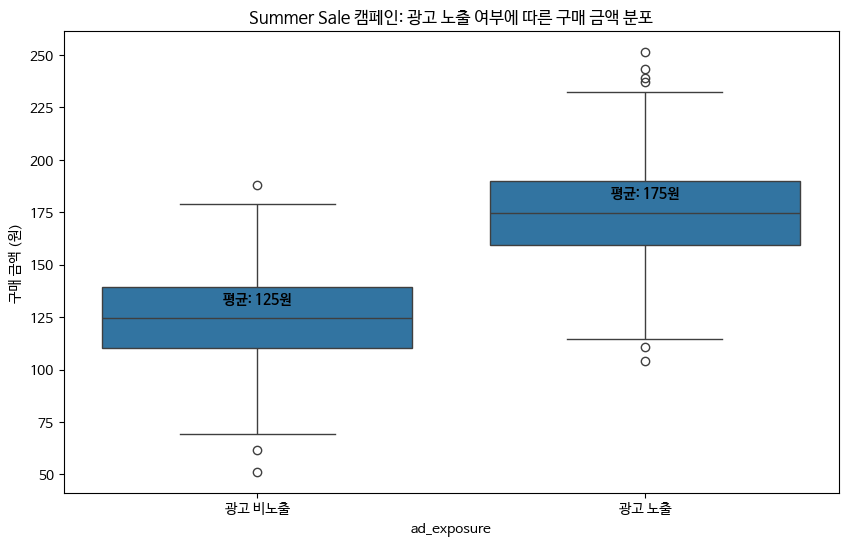

In [17]:
#2.6. 결과 시각화

plt.figure(figsize=(10, 6))
sns.boxplot(x='ad_exposure', y='purchase_amount', data=data_marketing)
plt.xticks([0, 1], ['광고 비노출', '광고 노출'])
plt.ylabel('구매 금액 (원)')
plt.title('Summer Sale 캠페인: 광고 노출 여부에 따른 구매 금액 분포')

# 평균값 표시
means = data_marketing.groupby('ad_exposure')['purchase_amount'].mean()
for i, mean_val in enumerate(means):
    plt.text(i, mean_val + 5, f'평균: {mean_val:.0f}원', ha='center', va='bottom', fontweight='bold')
plt.show()


#광고 노출 그룹의 상자가 광고 비노출 그룹보다 더 높다
  #광고를 본 고객이 보지 않은 고객보다 더 많은 돈을 지불한다

#광고 노출 그룹의 중앙값, 상자범위가 광고 비노출 그룹보다 높다
  #광고를 본 고객의 소비 수준이 전반적으로 상승하였다


#2.7. 경영진 보고서 작성

📋 경영진 보고서: Summer Mega Sale 캠페인 효과 분석
==================================================
🎯 핵심 성과 지표

• 광고 노출 그룹 평균 구매 금액:175원

• 광고 비노출 그룹 평균 구매 금액: 125원

• 순수 광고 효과 (통제 후): 광고 노출은 타 요인을 통제한 후, 개인당 구매액을 평균 약 51원 증가시킨다.

• 모델 설명력 (R²): 59.7%.

• 광고 ROI: -100.0%

💡 전략적 권장사항:
- 광고 효과 자체는 긍정적이었으나, 광고 비용이 과도하였다.
- 9월 추석 캠페인 전략: 광고가 효과가 있다는 것은 검증되었기에 비용적으로도 효율적인 광고 채널에서 운영될 수 있도록 하는 비용 절감 및 성과 중심의 광고 캠페인 전략을 실행한다. 이는 광고 캠페인을 진행하되, 기존의 광고 방식에서 더 저렴한 방식(이메일 마케팅, 소셜 미디어, 라디오 등)을 선택하여 광고 당 들어가는 비용을 줄인다.
- 예산 배분: 기존의 광고 당 높은 투자 금액 대신, 저비용 광고 채널로 소액으로 예산을 잡아 광고를 통해 발생하는 이익을 증대시킨다.
- 타켓 고객층 선정: 고소득, 저소득층에 따른 광고 노출보다는, 광고 노출 유무 자체가 중요하였다. 저비용으로 최대한 많은 타켓에게 광고를 노출시키는 것이 중요하다.

⚠️ 리스크 요소:
- 무작위 통제 실험이 아니기 때문에, 측정되지 않은 다른 요인이 결과에 영향을 미쳤을 수도 있다. 인과관계 해석이 올바르게 되지 않았을 수도 있다.
- 브랜드 이미지, 고객 충성도 등 광고의 장기적, 간접적인 가치는 분석에 포함되지 않았다. 따라서 장기 효과가 미측정된 점이 제한점이다.

📅 향후 액션 아이템:
- A/B 테스트 도입으로 광고 노출 그룹과 미노출 그룹을 무작위로 나눠 광고의 순수 효과를 검증한다.
- 과거 구매 이력, 광고 클릭률, 광고 노출률 등 추가적인 데이터 수집 강화로 좀더 유의미한 분석을 진행하도록 한다.
- 캠페인 진행 전, 예상 광고 효과와 비용을 바탕으로 사전에 ROI를 계산해보는 과정을 통해, 수익성을 예측하고 투자를 결정하는 과정을 추가한다.

In [18]:
#3. 고객 세분하 및 예측 모델링 보고서

np.random.seed(789)
n_users = 500
data_streaming = pd.DataFrame({
    'watch_hours': np.random.lognormal(np.log(10), 0.5, n_users),
    'content_diversity': np.random.uniform(1, 10, n_users),
    'subscription_duration': np.random.exponential(12, n_users),
    'satisfaction_score': np.random.normal(7, 1.5, n_users)
})
churn_prob = 1 / (1 + np.exp((data_streaming['satisfaction_score'] - 5) +
                              0.1*data_streaming['watch_hours'] -
                              0.05*data_streaming['subscription_duration']))
data_streaming['churn'] = np.random.binomial(1, churn_prob)

print("🛍️ 스트리밍 데이터 미리보기")
print(data_streaming.describe().round(2))
print(f"\n전체 이탈률: {data_streaming['churn'].mean()*100:.1f}%")


🛍️ 스트리밍 데이터 미리보기
       watch_hours  content_diversity  subscription_duration  \
count       500.00             500.00                 500.00   
mean         11.40               5.49                  12.22   
std           6.21               2.56                  12.30   
min           2.33               1.02                   0.04   
25%           7.25               3.30                   3.10   
50%          10.21               5.49                   8.00   
75%          14.00               7.71                  17.10   
max          61.74              10.00                  79.01   

       satisfaction_score   churn  
count              500.00  500.00  
mean                 7.03    0.15  
std                  1.54    0.36  
min                  2.73    0.00  
25%                  6.09    0.00  
50%                  7.02    0.00  
75%                  8.02    0.00  
max                 11.63    1.00  

전체 이탈률: 15.0%


In [19]:
#3.1. 데이터 표준화 및 PCA

features = ['watch_hours', 'content_diversity', 'subscription_duration', 'satisfaction_score']
X = data_streaming[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA 설명된 분산 비율: {pca.explained_variance_ratio_.round(3)}")
print(f"누적 설명 분산: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# PCA 성분 해석
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['주성분1', '주성분2'],
    index=features
)
print("\n📊 PCA 성분 분석 (각 변수의 기여도)")
print(feature_importance.round(3))

#주성분1: 사용자의 서비스 참여 및 만족도
  #높을수록 시청 시간이 길고, 컨텐츠가 다양하고, 서비스 만족도가 높다
#주성분2: 장기 구독은 높은 양의 기여도, 콘텐스 다양성은 높은 음의 기여도
  #높을수록 한 가지 콘텐츠를 오래 구독하는 충성도가 높은 장기 고객이다
  #낮을수록 구독 기간을 짧지만 다양한 콘텐츠를 본다

PCA 설명된 분산 비율: [0.27  0.249]
누적 설명 분산: 51.9%

📊 PCA 성분 분석 (각 변수의 기여도)
                        주성분1   주성분2
watch_hours            0.524  0.246
content_diversity      0.500 -0.493
subscription_duration  0.337  0.796
satisfaction_score     0.602 -0.250


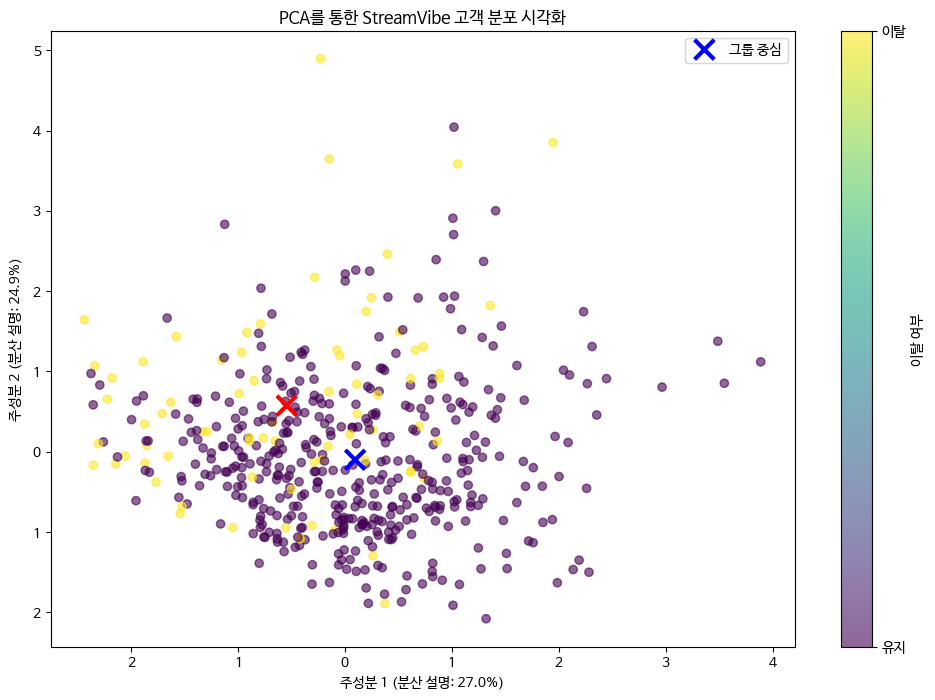

In [20]:
#3.2. PCA 결과 시각화

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_streaming['churn'], alpha=0.6, cmap='viridis')
plt.xlabel(f'주성분 1 (분산 설명: {pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'주성분 2 (분산 설명: {pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA를 통한 StreamVibe 고객 분포 시각화')
cbar = plt.colorbar(scatter, label='이탈 여부')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['유지', '이탈'])

# 이탈/유지 고객 중심점 표시
churn_centers = data_streaming.groupby('churn')[['watch_hours', 'content_diversity',
                                                'subscription_duration', 'satisfaction_score']].mean()
churn_centers_scaled = scaler.transform(churn_centers)
churn_centers_pca = pca.transform(churn_centers_scaled)
plt.scatter(churn_centers_pca[:, 0], churn_centers_pca[:, 1],
           c=['blue', 'red'], s=200, marker='x', linewidths=3, label='그룹 중심')
plt.legend()
plt.show()


#파란색 X(유지그룹): 주성분 1은 높고 주성분 2는 낮다
  #참여, 만족도가 높은 충성 고객이다
#빨간색 X(이탈그룹): 주성분 1은 낮고 주성분 2는 높다
  #이탈도가 높은 그룹임으로 이를 타켓으로 만족도를 높이고 이탈 방지 마케팅을 세워야 한다

In [21]:
#3.3. 고객 세분화

kmeans = KMeans(n_clusters=3, random_state=789)
data_streaming['cluster'] = kmeans.fit_predict(X_scaled)
cluster_summary = data_streaming.groupby('cluster')[features + ['churn']].mean()

print("📊 고객 세그먼트별 특징 분석")
print(cluster_summary.round(2))

# 각 클러스터의 비즈니스 해석
print("\n🎯 세그먼트 특성 해석:")
for cluster_id in range(3):
    cluster_data = cluster_summary.loc[cluster_id]
    churn_rate = cluster_data['churn'] * 100

    print(f"\n[세그먼트 {cluster_id}] - 이탈률: {churn_rate:.1f}%")
    print(f"  • 월 시청시간: {cluster_data['watch_hours']:.1f}시간")
    print(f"  • 콘텐츠 다양성: {cluster_data['content_diversity']:.1f}/10")
    print(f"  • 구독기간: {cluster_data['subscription_duration']:.1f}개월")
    print(f"  • 만족도: {cluster_data['satisfaction_score']:.1f}/10")

    # 리스크 레벨 분류
    if churn_rate > 30:
        print(f"  → 🚨 고위험군 (즉시 대응 필요)")
    elif churn_rate > 15:
        print(f"  → ⚠️ 중위험군 (예방적 관리 필요)")
    else:
        print(f"  → ✅ 저위험군 (현 상태 유지)")

# 세그먼트 크기
segment_sizes = data_streaming['cluster'].value_counts().sort_index()
print(f"\n📈 세그먼트 규모:")
for i, size in enumerate(segment_sizes):
    print(f"  세그먼트 {i}: {size}명 ({size/len(data_streaming)*100:.1f}%)")


#세그먼트 0
  #다양한 콘텐츠를 적극적으로 소비
  #새로운 콘텐츠 추천시, 긍정적인 반응일 것
  #전략: 현재 상태를 유지하며, 새로운 콘텐츠를 발견할 수 있도록 개인화 추천을 정교화하는 것이 좋을 듯하다

#세그먼트 1
  #구독기간, 시청시간은 가장 길지만, 이탈률이 가장 높다
  #장기 충성 고객이지만 이탈률이 높다
  #콘텐츠 피로감이나, 서비스에 대한 기대치가 높아져 사소한 것에도 불만감이 높아져 이탈로 이어질 수도 있다
  #전략: 가장 전략이 우선시 되어야 한다. 장기고객 전용 행택 등 충성도에 보답할 수 있는 전략 제공 필요

#세그먼트 2
  #콘텐츠 다양성, 만족도가 가장 낮다. 이탈률은 적당하다
  #소수의 익숙한 콘텐츠 소비
  #서비스 만족도가 낮고, 소극적이기에 대안이 나타나면 언제든지 이탈할 수 있다 > 잠재적 이탈 위험 그룹
  #전략: 콘텐츠 다양성을 높이고 서비스 참여를 높일 수 있는 전략 실행으로 만족도 개선

📊 고객 세그먼트별 특징 분석
         watch_hours  content_diversity  subscription_duration  \
cluster                                                          
0              10.62               7.69                   7.81   
1              13.92               5.56                  31.43   
2              10.95               3.10                   7.12   

         satisfaction_score  churn  
cluster                             
0                      7.32   0.09  
1                      7.15   0.25  
2                      6.67   0.16  

🎯 세그먼트 특성 해석:

[세그먼트 0] - 이탈률: 9.2%
  • 월 시청시간: 10.6시간
  • 콘텐츠 다양성: 7.7/10
  • 구독기간: 7.8개월
  • 만족도: 7.3/10
  → ✅ 저위험군 (현 상태 유지)

[세그먼트 1] - 이탈률: 25.3%
  • 월 시청시간: 13.9시간
  • 콘텐츠 다양성: 5.6/10
  • 구독기간: 31.4개월
  • 만족도: 7.2/10
  → ⚠️ 중위험군 (예방적 관리 필요)

[세그먼트 2] - 이탈률: 16.0%
  • 월 시청시간: 10.9시간
  • 콘텐츠 다양성: 3.1/10
  • 구독기간: 7.1개월
  • 만족도: 6.7/10
  → ⚠️ 중위험군 (예방적 관리 필요)

📈 세그먼트 규모:
  세그먼트 0: 207명 (41.4%)
  세그먼트 1: 99명 (19.8%)
  세그먼트 2: 194명 (38.8%)


In [22]:
#3.4. 이탈 예측 모델

X_logistic = X_scaled
y_logistic = data_streaming['churn']
logistic_model = LogisticRegression(random_state=789)

logistic_model.fit(X_logistic, y_logistic)

y_pred_proba = logistic_model.predict_proba(X_logistic)[:, 1]
y_pred = logistic_model.predict(X_logistic)

accuracy = (y_pred == y_logistic).mean()
print(f"이탈 예측 모델 정확도: {accuracy:.3f} ({accuracy*100:.1f}%)")

# 변수별 중요도 분석
feature_importance = pd.DataFrame({
    '변수': features,
    '계수': logistic_model.coef_[0],
    '중요도': np.abs(logistic_model.coef_[0])
}).sort_values('중요도', ascending=False)

print("\n📊 이탈 예측 주요 변수")
print(feature_importance.round(3))

# 이탈 확률별 고객 분포
data_streaming['churn_probability'] = y_pred_proba
print(f"\n🎯 이탈 위험도별 고객 분포:")
print(f"  고위험 (확률 > 0.7): {(y_pred_proba > 0.7).sum()}명")
print(f"  중위험 (0.3 < 확률 ≤ 0.7): {((y_pred_proba > 0.3) & (y_pred_proba <= 0.7)).sum()}명")
print(f"  저위험 (확률 ≤ 0.3): {(y_pred_proba <= 0.3).sum()}명")


#정확도: 87%로 믿을 만한 수치이다

#만족도 하락: 이탈을 예측하는데 가장 강력한 변수이다,
#구독 기간: 구독기간이 증가할수록 이탈확률이 높아진다 > 콘텐츠 피로감이나 서비스 기대치와 연결지을 수 있다
#시청시간: 시청시간이 줄어들수록 이탈할 가능성이 높다 > 고객의 관심이 줄어들기 때문

#이탈확률 70% 이상 그룹 11명 > 만족도가 낮아진 장기 고객일 가능성이 높다
  #장기 구독에 대한 혜택이나 쿠폰 등으로 이탈 방지
#2순위 69명 > 중위험 그룹으로 개인화된 콘텐츠 추천을 강화하여 시청 시찬을 늘리고 만족도를 높일 수 있는 방안 모색


이탈 예측 모델 정확도: 0.870 (87.0%)

📊 이탈 예측 주요 변수
                      변수     계수    중요도
3     satisfaction_score -1.366  1.366
2  subscription_duration  0.599  0.599
0            watch_hours -0.441  0.441
1      content_diversity  0.028  0.028

🎯 이탈 위험도별 고객 분포:
  고위험 (확률 > 0.7): 11명
  중위험 (0.3 < 확률 ≤ 0.7): 69명
  저위험 (확률 ≤ 0.3): 420명


In [23]:
#3.5. 모델 성능 분석

cm = confusion_matrix(y_logistic, y_pred)
tn, fp, fn, tp = cm.ravel()

print("📋 이탈 예측 모델 성능 분석")
print(f"정확히 예측한 유지 고객 (True Negative): {tn}명")
print(f"이탈로 잘못 예측한 유지 고객 (False Positive): {fp}명")
print(f"유지로 잘못 예측한 이탈 고객 (False Negative): {fn}명")
print(f"정확히 예측한 이탈 고객 (True Positive): {tp}명")

# 비즈니스 메트릭 계산
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n🎯 비즈니스 성과 지표:")
print(f"정밀도 (Precision): {precision:.3f} - 이탈 예측 중 실제 이탈 비율")
print(f"재현율 (Recall): {recall:.3f} - 실제 이탈 고객 중 예측 성공 비율")
print(f"F1-Score: {f1_score:.3f} - 종합 성능 지표")

# 비즈니스 손실 분석
retention_cost_per_customer = 50000  # 고객 유지 비용 (쿠폰, 할인 등)
lost_revenue_per_churn = 200000     # 이탈 고객당 매출 손실

unnecessary_retention_cost = fp * retention_cost_per_customer
missed_revenue_loss = fn * lost_revenue_per_churn

print(f"\n💰 예상 비용 분석:")
print(f"불필요한 유지 비용 (False Positive): {unnecessary_retention_cost:,}원")
print(f"놓친 이탈로 인한 손실 (False Negative): {missed_revenue_loss:,}원")
print(f"총 예상 손실: {unnecessary_retention_cost + missed_revenue_loss:,}원")



#재현율= 28%, 정밀도 65.6%
  #재현율이 낮아 실제로 이탈하는 고객을 잘 예측하고 있지 않다

#비즈니스 성과
  #불필요한 유지 비용: 55만원 > 일반 고객을 이탈자로 잘못 예측해 발생한 비용
  #놓친 이탈로 인한 손실: 1080만원 > 실제 이탈 고객을 놓쳐 발생한 매출 손실

  #놓쳐서 발생한 손실이 잘못 예측해서 쓰인 비용보다 약 20배 정도 크다


#재현율을 높이는 방향으로 모델을 튜닝해야 한다
#즉, 재현율을 높이는 과정에서 정밀도가 떨어져 유지비용이 증가하더라도, 이탈 손실을 줄이는 것이 더 중요하다

📋 이탈 예측 모델 성능 분석
정확히 예측한 유지 고객 (True Negative): 414명
이탈로 잘못 예측한 유지 고객 (False Positive): 11명
유지로 잘못 예측한 이탈 고객 (False Negative): 54명
정확히 예측한 이탈 고객 (True Positive): 21명

🎯 비즈니스 성과 지표:
정밀도 (Precision): 0.656 - 이탈 예측 중 실제 이탈 비율
재현율 (Recall): 0.280 - 실제 이탈 고객 중 예측 성공 비율
F1-Score: 0.393 - 종합 성능 지표

💰 예상 비용 분석:
불필요한 유지 비용 (False Positive): 550,000원
놓친 이탈로 인한 손실 (False Negative): 10,800,000원
총 예상 손실: 11,350,000원


📊 AUC 성능 평가: 0.851 → 우수함 (상용화 가능 수준)


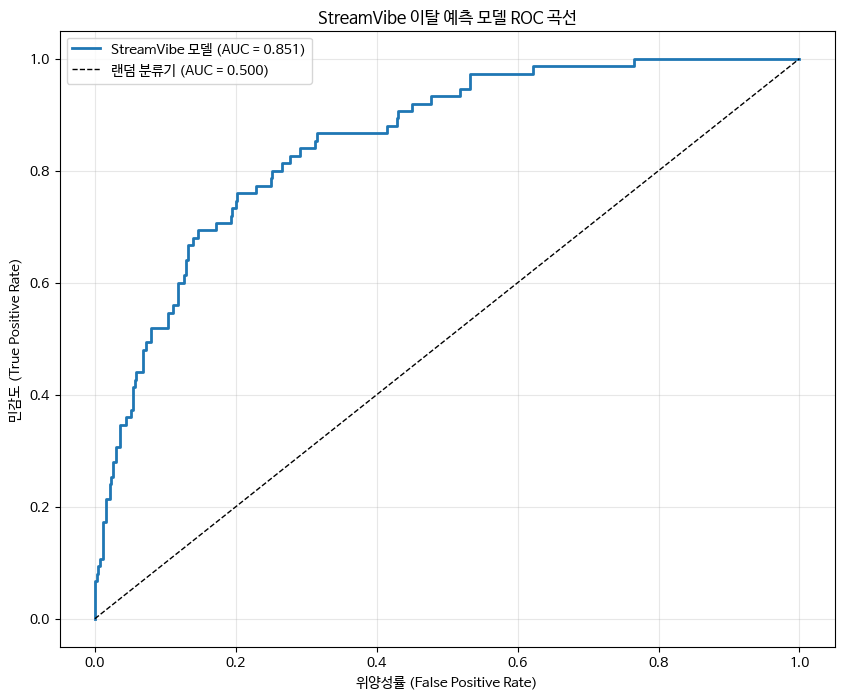

🎯 최적 예측 임계값: 0.165
   이 임계값에서 민감도: 0.760, 특이도: 0.798


In [28]:
#3.6. ROC곡선과 AUC

fpr, tpr, thresholds = roc_curve(y_logistic, y_pred_proba)
roc_auc = roc_auc_score(y_logistic, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'StreamVibe 모델 (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='랜덤 분류기 (AUC = 0.500)')
plt.xlabel('위양성률 (False Positive Rate)')
plt.ylabel('민감도 (True Positive Rate)')
plt.title('StreamVibe 이탈 예측 모델 ROC 곡선')
plt.legend()
plt.grid(True, alpha=0.3)

# AUC 성능 해석
if roc_auc > 0.9:
    performance_level = "탁월함 (업계 최고 수준)"
elif roc_auc > 0.8:
    performance_level = "우수함 (상용화 가능 수준)"
elif roc_auc > 0.7:
    performance_level = "양호함 (개선 여지 있음)"
else:
    performance_level = "부족함 (추가 개선 필요)"

print(f"📊 AUC 성능 평가: {roc_auc:.3f} → {performance_level}")
plt.show()

# 최적 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"🎯 최적 예측 임계값: {optimal_threshold:.3f}")
print(f"   이 임계값에서 민감도: {tpr[optimal_idx]:.3f}, 특이도: {1-fpr[optimal_idx]:.3f}")


#최적 임계값= 0.165 : 고객의 이탈 확률이 16.5%만 넘어도 위험군으로 분류하여 대응하는 것이 좋다

#민감도: 76%, 특이도: 79.8%  > 적당한 모델의 성능으로 불필요한 마케팅 비용을 줄인다

#충성고객 20%에게 불필요한 쿠폰을 주는 것보단, 이탈고객 76%에게 혜택을 주는 것이 더 이득이다
  #고객을 놓쳤을 때의 손실이 불필요한 유지 비용보다 더 크기 때문
  #최적 임계값을 통한 이탈 위험군 정의 > 최소한의 비용으로 최대의 이탈 방지 효과 기대 가능

#3.7. 경영진 보고서 작성

📋 경영진 보고서: StreamVibe 고객 이탈 방지 전략
==================================================
🚨 현재 상황
• 전체 이탈률: 15.0%

• 고객 세그먼트 수: 3개

• 이탈 예측 모델 AUC: 0.851

• 모델 정확도: 87%

🎯 핵심 발견사항
1. 고위험 세그먼트 특성:
- 구독기간, 시청시간은 가장 길지만, 이탈률이 가장 높다
- 장기 충성 고객이지만 이탈률이 높다
- 콘텐츠 피로감이나, 서비스에 대한 기대치가 높아져 사소한 것에도 불만감이 높아져 이탈로 이어질 수도 있다


2. 이탈 주요 예측 변수:
- 주요 원인: 고객 만족도(낮을 수록), 구독 기간(길수록), 시청 시간(짧을 수록) 순으로 중요도가 높다

3. 예측 가능한 이탈 고객:
- 이탈 확률 70% 이상의 위험군은 11명으로 식별됨

💡 즉시 실행 가능한 대응 전략
1. 선제적 고객 유지:
- 이탈확률 16.5% 이상을 위험군으로 정의하고, 초위험군으로 식별된 11명에게는 즉시 이탈 방지 전략을 수행한다 (즉각적으로 사용할 수 있는 쿠폰, 장기 구독 감사 쿠폰 및 혜택 등)

2. 세그먼트별 맞춤 전략:
- 세그먼트 0(저위험군): 다양한 콘텐츠를 적극적으로 소비하는 그룹으로 새로운 콘텐츠를 추천할 경우, 긍정적인 반응일 것이다. 따라서 현재 상태를 유지하며 새로운 콘텐츠를 지속적으로 추천하되, 개인 맞춤형으로 추천할 수 있는 정교한 시스템을 도입한다.
- 세그먼트 1(고위험군): 장기 충성 고객을 위한 독점 콘텐츠 선공개, 신규 기능 우선 체험 기능, 프리미엄 제도 도입 등으로 보상 체계 수립
- 세그먼트 2(중위험군):소수의 익숙한 콘텐츠를 소비하며 언제든 이탈할 수 있는 그룹이다. 만족도 조사를 통해 불만 원인을 파악하고 직접 개선할 수 있도록 하여 참여율을 높여 적극적으로 서비스를 이용할 수 있도록 한다.


3. 콘텐츠 전략 개선: 장기 충성 고객의 데이터를 분석하여 피로감을 유발하는 패턴 파악, 이탈 전에 소비할 수 있는 콘텐츠를 분석하여 전략적으로 제공한다

📈 예상 효과
• 이탈률 감소 목표:
- 현재 이탈률 15%에서 10% 미만으로 줄여 9%대 로 감소시키는 것을 목표(현재 대비 약 40% 감소 효과 기대 가능)

• 예상 매출 회복:
- 고객 1명 이탈시 매출 손실을 20만원으로 설정하였으며, FN은 54명이였음. 따라서 모델이 놓친 고객으로 인해 발생한 총 매출 손실 =10,800,000원
- 이 수치의 절반 이상을 회복하는 것을 목표로 하여 6백만원 이상을 매출 회복 목표치로 제시

• ROI:
- >  이탈 위험군(80명) 대상 유지 캠페인에 약 400만원을 투자하여 600만원의 매출 손실을 방지, 투자금 대비 50%의 높은 투자 수익률이 기대됨


- 고위험군+중위험군= 80명
- 고객 1명 유지 비용: 5만원
- 캠페인에 필요한 총 투자비용= 4,000,000원

-예상 매출 회복액은 6백만원
  - 순수익 = 수익 - 투자비용 = 2백만원

- ROI= (순수익/총 투자비용)*100=50%

⏰ 실행 일정 (향후 3개월)
- ~ 1개월: 이탈 위험군 자동 식별 대시보드 구축 및 연동. 세그먼트별 맞춤형 이탈 방지 및 유지 캠페인 기획
- ~2개월: A/B 테스트를 통한 파일럿 캠페인 실행. 핵심 성과 지표를 통한 모니터링 및 결과 타당성 얻기
- ~3개월: 캠페인 성과 및 ROI 종합 분석, 전략 최적화 및 확대 적용을 위한 계획 기획

🔧 필요 리소스
- 인력: 데이터 분석팀, 마케팅팀(전략 기획 및 실행), CS팀(고객과 직접 소통)
- 예산: 이탈 방지 및 유지 캠페인을 위한 마케팅 비용(쿠폰, 투자 등 예산 필요)
- 시스템: 실시간 데이터 분석, 시각화 대시보드, 마케팅 자동화 시스템 필요
